In [1]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import parameter_optimization as po
import pickle

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

# pull in flags_df and limit to iMs listed
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
flags_df = flags_df[flags_df['include'] == True]

In [2]:
# settings loading data
# settings
case = 'Arginine'
metabolites = ['Arginine']#['Guanine', 'Hypoxanthine']
act_iM = None
inh_iM = 'Arginine'
plot_gene = 'argA'
plot_regulator = 'argR'

if True:
    true_false = []
    for act, inh in zip(flags_df['act_iM'], flags_df['inh_iM']):
        if act in [case] or inh in [case]:
            true_false.append(True)
        else:
            true_false.append(False)
    bby_flags_df = flags_df.loc[true_false]

    # load in relevant data
    starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
    # above is in (µM) , convert to M
    starve_metabs[starve_metabs.columns[1:]] *= 1e-6
    starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
    #starve_cols = list(set(starve_log_tpm.columns).intersection(actual_df.columns))

    iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
    run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
    GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
    GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    metab_df = inh_metab_df[inh_metab_df['iM'] == case]
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)



    # grab genes
    genes = cInh_mapping[cInh_mapping[inh_iM] != 0].index.to_list()

    # load in for loop
    calc_cInh = GAMS_calc_cInh[genes]
    calc_cAct = GAMS_calc_cAct[genes]
    mRNA_ratio_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0).loc[calc_cInh.index]


    # creating actual and reconstructed mRNA values
    all_shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    recons_mRNAs = []
    actual_mRNAs = []
    indices_for_recons = []
    grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
    ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
    for gene in calc_cAct.columns:
        shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)).intersection(ratios_df.index[ratios_df[gene].notnull()]))

        actual_mRNAs.append(ratios_df.loc[shared][gene])
        # setup
        #po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))
        pickle_in = open('../data/lambda_dfs/'+gene+'.pkl', 'rb')
        lambda_df = pickle.load(pickle_in)
        pickle_in.close()

        recon_mRNA = []
        for sample in shared:
            cAct = calc_cAct[gene].loc[sample]
            cInh = calc_cInh[gene].loc[sample]
            lambda_df1 = lambda_df[gene].loc[sample]
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp'], lambda_df_input = lambda_df1))
        recons_mRNAs.append(recon_mRNA)
        indices_for_recons.append(gene)

    # save recon
    recon_df = pd.DataFrame(recons_mRNAs, index = indices_for_recons, columns = all_shared)
    actual_df = pd.DataFrame(actual_mRNAs, index = indices_for_recons, columns = all_shared)

In [ ]:
# let's plot metaboltie concentration

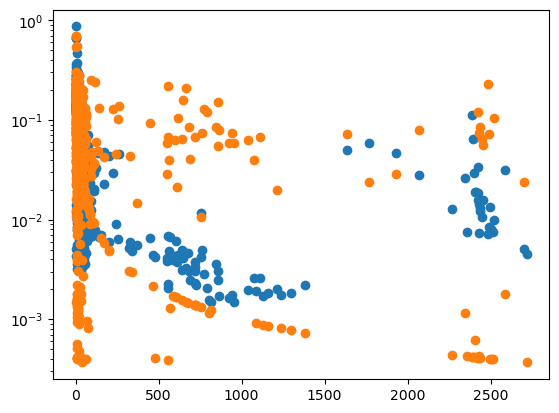

In [5]:
# GARBAGE plotting

plt.scatter(calc_cInh[gene_to_b[plot_gene]], mRNA_ratio_df[gene_to_b[plot_gene]])
plt.scatter(calc_cInh[gene_to_b[plot_gene]], recon_df[mRNA_ratio_df.index].loc[gene_to_b[plot_gene]])
plt.yscale('log')
plt.show()

In [32]:
mRNA_ratio_df[[gene_to_b[plot_gene]]]

,b2818
p1k_00040,1.397902
p1k_01008,0.654503
p1k_00971,0.668994
p1k_00886,1.715660
p1k_00946,0.494703
...,...
p1k_00834,0.109106
p1k_00399,0.617072
starve_series__t16_starve,0.033827
p1k_00420,1.322775


In [37]:
recon_df[mRNA_ratio_df.index].loc[[gene_to_b[plot_gene]]].T

,b2818
p1k_00040,0.997717
p1k_01008,0.362230
p1k_00971,0.102839
p1k_00886,0.997717
p1k_00946,0.098540
...,...
p1k_00834,0.029779
p1k_00399,0.342017
starve_series__t16_starve,0.009043
p1k_00420,0.874524


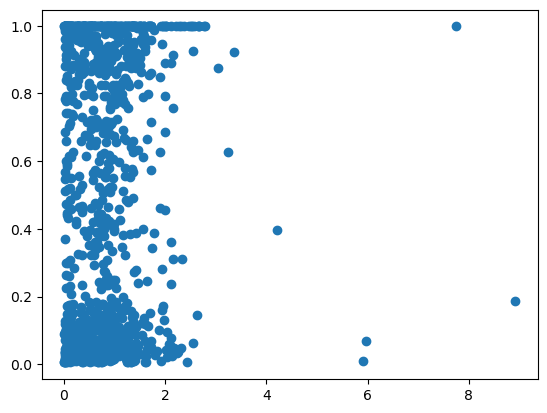

In [39]:
plt.scatter(mRNA_ratio_df[gene_to_b[plot_gene]], recon_df[mRNA_ratio_df.index].loc[[gene_to_b[plot_gene]]].T)
#plt.yscale('log')